In [1]:
%matplotlib inline
import os
import sys
import argparse
import torch
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from configs.defaults import _C as cfg
from modules.hardnet.models import HardNet

# Configuration
# Set to False to load the "Cartesian" models used in the paper
USE_LOG_POLAR = True
IMG_FILENAME = 'testImg.jpeg'

In [2]:
# Function definitions
def plot_image(axes, image):
    axes.grid(False)
    axes.imshow(image, cmap=plt.get_cmap('gray'))
    axes.set_xlim(0, image.shape[1])
    axes.set_ylim(image.shape[0], 0)
    axes.axis('off')

In [3]:
# Setup
ROOT = os.getcwd()

if USE_LOG_POLAR:
    config_path = os.path.join(ROOT, 'configs', 'init_one_example_ptn_96.yml')
else:
    config_path = os.path.join(ROOT, 'configs', 'init_one_example_stn_16.yml')

cfg.merge_from_file(config_path)
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
torch.cuda.manual_seed_all(cfg.TRAINING.SEED)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

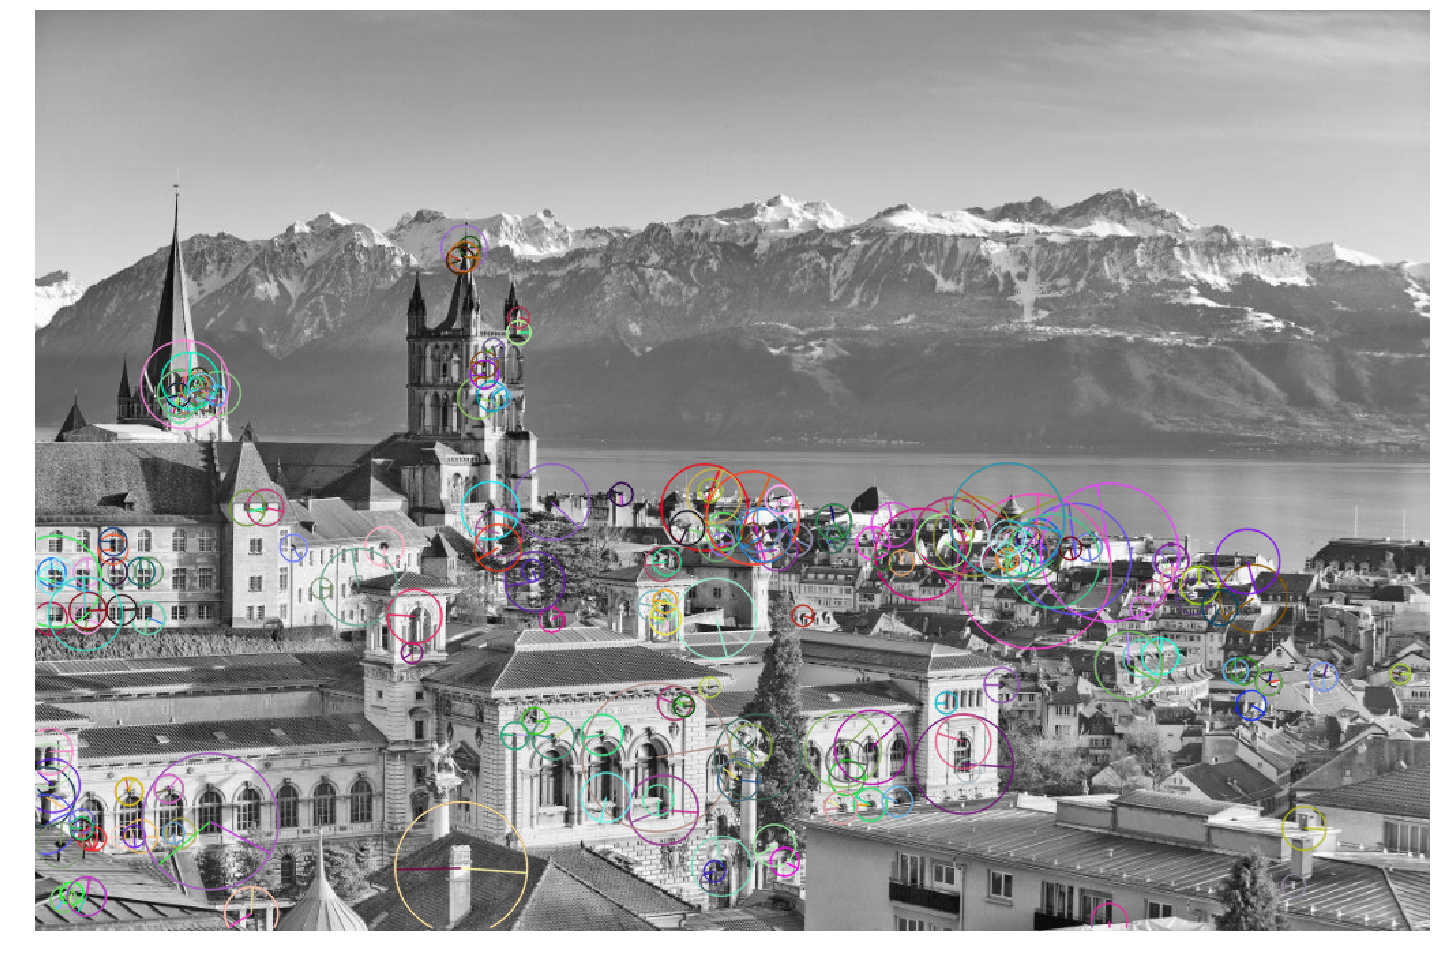

Padding image from 676x1024 to 1500x1500


In [4]:
# Extract SIFT keypoints
img = cv2.imread(IMG_FILENAME, cv2.IMREAD_GRAYSCALE)

# A safe image size is ~1000px on the largest dimension
# To extract features on larger images you might want to increase the padding
max_size = 1024
if any([s > max_size for s in img.shape]):
    h, w = img.shape
    if h > w:
        img = cv2.resize(img, (int(w * max_size / h), max_size), cv2.INTER_CUBIC)
    elif w > h:
        img = cv2.resize(img, (max_size, int(h * max_size / w)), cv2.INTER_CUBIC)
h, w = img.shape

# get keypoints, scale and locatinos from SIFT or another detector
sift = cv2.xfeatures2d.SIFT_create(256)
keypoints = sift.detect(img, None)

pts = np.array([kp.pt for kp in keypoints])
scales = np.array([kp.size for kp in keypoints])
oris = np.array([kp.angle for kp in keypoints])

fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111)
scaling_factor = 96 / 12 if USE_LOG_POLAR else 1
cv_kp = [cv2.KeyPoint(p[0], p[1], scaling_factor * s, o) for p, s, o in zip(pts, scales, oris)]
img_with_kp = cv2.drawKeypoints(
    img, cv_kp, None, None, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plot_image(axes, img_with_kp)
plt.show()

# Mirror-pad the image to avoid boundary effects
if any([s > cfg.TEST.PAD_TO for s in img.shape[:2]]):
    raise RuntimeError (
        "Image exceeds acceptable size ({}x{}), please downsample".format(
            cfg.TEST.PAD_TO, cfg.TEST.PAD_TO))

fillHeight = cfg.TEST.PAD_TO - img.shape[0]
fillWidth = cfg.TEST.PAD_TO - img.shape[1]

padLeft = int(np.round(fillWidth / 2))
padRight = int(fillWidth - padLeft)
padUp = int(np.round(fillHeight / 2))
padDown = int(fillHeight - padUp)

img = np.pad(img,
             pad_width = ((padUp, padDown), (padLeft, padRight)),
             mode = 'reflect')
print('Padding image from {}x{} to {}x{}'.format(h, w, img.shape[0], img.shape[1]))

# fig = plt.figure(figsize=(25,25))
# axes = fig.add_subplot(111)
# cv_kp = [cv2.KeyPoint(p[0] + padLeft, p[1] + padUp, scaling_factor * s, o) for p, s, o in zip(pts, scales, oris)]
# img_with_kp = cv2.drawKeypoints(
#     img, cv_kp, None, None, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# plot_image(axes, img_with_kp)
# plt.show()

In [5]:
# Normalize keypoint locations
kp_norm = []
for i, p in enumerate(pts):
    _p = 2 * np.array([(p[0] + padLeft) / (cfg.TEST.PAD_TO),
                       (p[1] + padUp) / (cfg.TEST.PAD_TO)]) - 1
    kp_norm.append(_p)

theta = [torch.from_numpy(np.array(kp_norm)).float().squeeze(),
         torch.from_numpy(scales).float(),
         torch.from_numpy(np.array([np.deg2rad(o) for o in oris])).float()]

In [6]:
# Instantiate the model
model = HardNet(
    transform = cfg.TEST.TRANSFORMER,
    coords = cfg.TEST.COORDS,
    patch_size = cfg.TEST.IMAGE_SIZE,
    scale = cfg.TEST.SCALE,
    is_desc256 = cfg.TEST.IS_DESC_256,
    orientCorrect = cfg.TEST.ORIENT_CORRECTION)

# Load weights
model.load_state_dict(
    torch.load(cfg.TEST.MODEL_WEIGHTS)['state_dict'])
model.eval()
model.to(device)

# Extract descriptors
imgs, img_keypoints = torch.from_numpy(img).unsqueeze(0).to(device), \
                      [theta[0].to(device), theta[1].to(device), theta[2].to(device)]

descriptors, patches = model(
    {IMG_FILENAME: imgs},
    img_keypoints,
    [IMG_FILENAME] * len(img_keypoints[0]))

print('Extracted: {} patches/descriptors'.format(len(descriptors)))

/usr/local/google/home/trulls/src/hardnet_ptn/modules/hardnet/models.py:144: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.6)


Extracted: 256 patches/descriptors


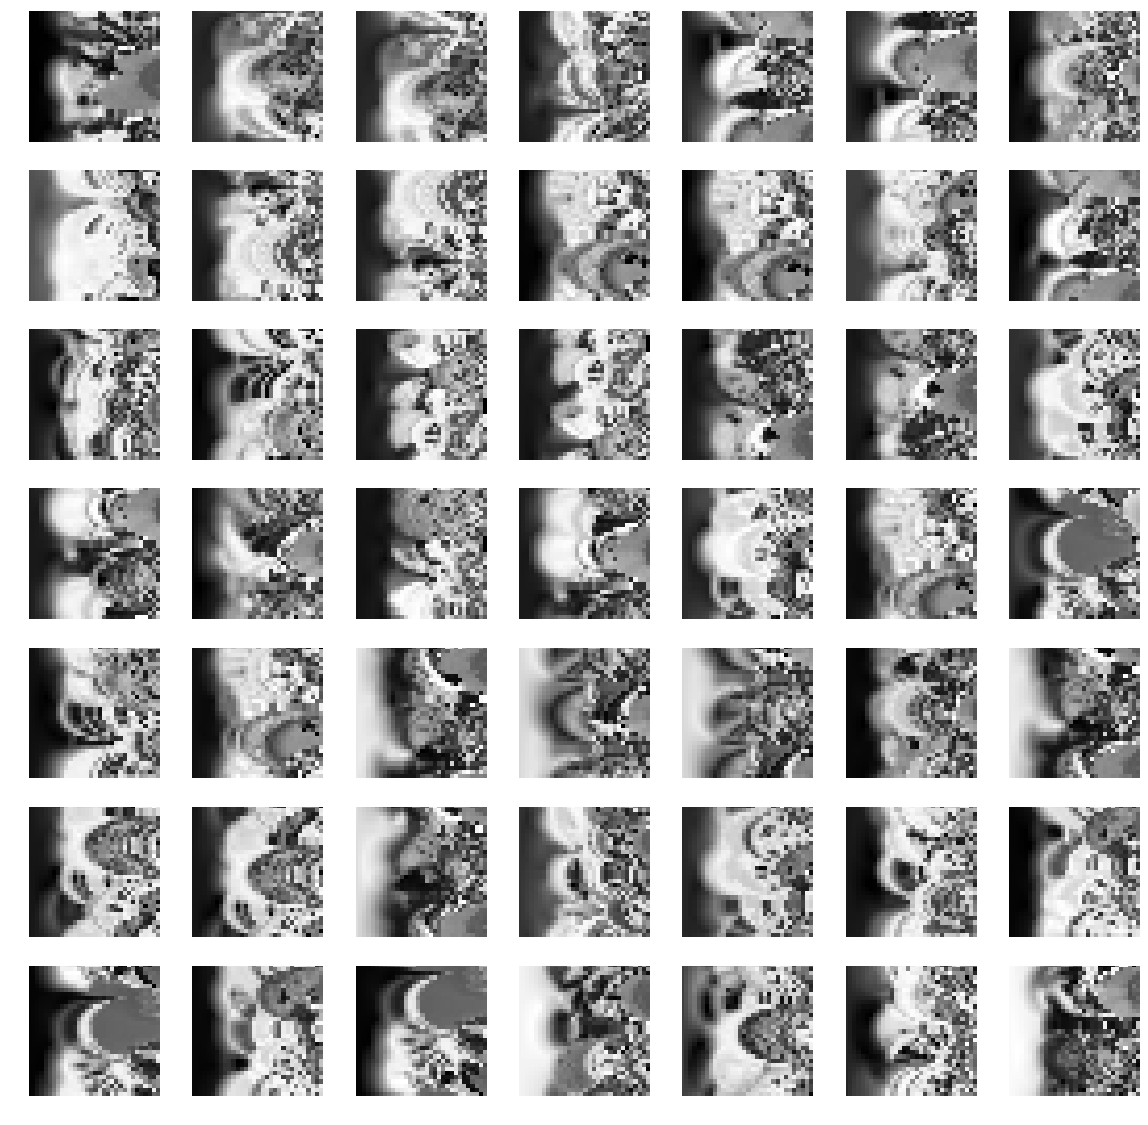

In [7]:
# Plot extracted patches
num_plot = 7
fig = plt.figure(figsize=(20, 20))
for j in range(num_plot):
    for i in range(num_plot):
        axes = fig.add_subplot(num_plot, num_plot, 1 + i + j * num_plot)
        plot_image(axes, patches[i + j * num_plot].squeeze().data.cpu().numpy())
plt.show()